In [83]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (20, 10)

In [84]:
df = pd.read_csv('data/treasury_rates.csv')

In [85]:
df

,DATE,DGS6MO,DGS1,DGS2,DGS5,DGS10,DGS30
0,1986-02-18,7.42,7.56,7.96,8.28,8.64,8.89
1,1986-02-19,7.51,7.67,8.06,8.37,8.7,8.92
2,1986-02-20,7.54,7.68,8.05,8.39,8.67,8.88
3,1986-02-21,7.42,7.56,7.93,8.24,8.48,8.73
4,1986-02-24,7.41,7.53,7.86,8.2,8.39,8.61
...,...,...,...,...,...,...,...
9188,2021-05-07,0.04,0.05,0.14,0.77,1.6,2.28
9189,2021-05-10,0.04,0.05,0.16,0.8,1.63,2.32
9190,2021-05-11,0.04,0.05,0.16,0.8,1.64,2.35
9191,2021-05-12,0.04,0.05,0.16,0.87,1.69,2.4


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9193 entries, 0 to 9192
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    9193 non-null   object
 1   DGS6MO  9193 non-null   object
 2   DGS1    9193 non-null   object
 3   DGS2    9193 non-null   object
 4   DGS5    9193 non-null   object
 5   DGS10   9193 non-null   object
 6   DGS30   9193 non-null   object
dtypes: object(7)
memory usage: 502.9+ KB


* Date needs to be set to datetime
* Other values should be floats.  I suspect this is because the null values are '.'

In [87]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9193 entries, 0 to 9192
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    9193 non-null   datetime64[ns]
 1   DGS6MO  9193 non-null   object        
 2   DGS1    9193 non-null   object        
 3   DGS2    9193 non-null   object        
 4   DGS5    9193 non-null   object        
 5   DGS10   9193 non-null   object        
 6   DGS30   9193 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 502.9+ KB


In [89]:
df.head(20)

,DATE,DGS6MO,DGS1,DGS2,DGS5,DGS10,DGS30
0,1986-02-18,7.42,7.56,7.96,8.28,8.64,8.89
1,1986-02-19,7.51,7.67,8.06,8.37,8.7,8.92
2,1986-02-20,7.54,7.68,8.05,8.39,8.67,8.88
3,1986-02-21,7.42,7.56,7.93,8.24,8.48,8.73
4,1986-02-24,7.41,7.53,7.86,8.2,8.39,8.61
5,1986-02-25,7.43,7.59,7.89,8.21,8.4,8.6
6,1986-02-26,7.42,7.57,7.88,8.07,8.36,8.54
7,1986-02-27,7.36,7.48,7.72,7.91,8.15,8.32
8,1986-02-28,7.36,7.43,7.71,7.91,8.13,8.27
9,1986-03-03,7.3,7.35,7.55,7.76,7.99,8.16


* The missing data here is from Christmas and New Years, which makes sense since the market is closed.
* I'll fill in the missing data from the value of the previous day.

In [90]:
df = df.replace('.', np.nan).ffill(axis=0)

In [91]:
df

,DATE,DGS6MO,DGS1,DGS2,DGS5,DGS10,DGS30
0,1986-02-18,7.42,7.56,7.96,8.28,8.64,8.89
1,1986-02-19,7.51,7.67,8.06,8.37,8.7,8.92
2,1986-02-20,7.54,7.68,8.05,8.39,8.67,8.88
3,1986-02-21,7.42,7.56,7.93,8.24,8.48,8.73
4,1986-02-24,7.41,7.53,7.86,8.2,8.39,8.61
...,...,...,...,...,...,...,...
9188,2021-05-07,0.04,0.05,0.14,0.77,1.6,2.28
9189,2021-05-10,0.04,0.05,0.16,0.8,1.63,2.32
9190,2021-05-11,0.04,0.05,0.16,0.8,1.64,2.35
9191,2021-05-12,0.04,0.05,0.16,0.87,1.69,2.4


In [92]:
df = df.rename(columns={'DATE': 'date',
                        'DGS6MO': 'mo_6',
                        'DGS1': 'yr_1',
                        'DGS2': 'yr_2',
                        'DGS5': 'yr_5',
                        'DGS10': 'yr_10',
                        'DGS30': 'yr_30'})

In [93]:
df.set_index('date', inplace=True)

In [94]:
df = df['1989':]

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8444 entries, 1989-01-02 to 2021-05-13
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mo_6    8444 non-null   object
 1   yr_1    8444 non-null   object
 2   yr_2    8444 non-null   object
 3   yr_5    8444 non-null   object
 4   yr_10   8444 non-null   object
 5   yr_30   8444 non-null   object
dtypes: object(6)
memory usage: 461.8+ KB


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8444 entries, 1989-01-02 to 2021-05-13
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mo_6    8444 non-null   object
 1   yr_1    8444 non-null   object
 2   yr_2    8444 non-null   object
 3   yr_5    8444 non-null   object
 4   yr_10   8444 non-null   object
 5   yr_30   8444 non-null   object
dtypes: object(6)
memory usage: 461.8+ KB


In [97]:
df =df.iloc[:,0:] = df.iloc[:,0:].astype('float')

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8444 entries, 1989-01-02 to 2021-05-13
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mo_6    8444 non-null   float64
 1   yr_1    8444 non-null   float64
 2   yr_2    8444 non-null   float64
 3   yr_5    8444 non-null   float64
 4   yr_10   8444 non-null   float64
 5   yr_30   8444 non-null   float64
dtypes: float64(6)
memory usage: 461.8 KB


In [99]:
df['ys'] = df['yr_10'] - df['mo_6']

In [100]:
df.describe()

,mo_6,yr_1,yr_2,yr_5,yr_10,yr_30,ys
count,8444.000000,8444.000000,8444.000000,8444.000000,8444.000000,8444.000000,8444.000000
mean,2.970870,3.091595,3.377055,3.959298,4.485083,5.017933,1.514212
std,2.497012,2.495160,2.504342,2.322941,2.111447,1.902097,1.135793
min,0.020000,0.050000,0.090000,0.190000,0.520000,0.990000,-0.790000
25%,0.380000,0.520000,0.910000,1.790000,2.610000,3.200000,0.530000
50%,2.490000,2.600000,3.025000,3.850000,4.370000,4.930000,1.460000
75%,5.162500,5.260000,5.520000,5.850000,6.060000,6.360000,2.470000
max,9.690000,9.850000,9.920000,9.750000,9.530000,9.310000,3.740000


In [101]:
df

,mo_6,yr_1,yr_2,yr_5,yr_10,yr_30,ys
date,,,,,,,
1989-01-02,8.67,9.02,9.14,9.14,9.14,9.00,0.47
1989-01-03,8.77,9.11,9.21,9.25,9.23,9.09,0.46
1989-01-04,8.87,9.14,9.25,9.24,9.22,9.08,0.35
1989-01-05,8.97,9.22,9.32,9.32,9.27,9.10,0.30
1989-01-06,8.97,9.20,9.32,9.30,9.25,9.06,0.28
...,...,...,...,...,...,...,...
2021-05-07,0.04,0.05,0.14,0.77,1.60,2.28,1.56
2021-05-10,0.04,0.05,0.16,0.80,1.63,2.32,1.59
2021-05-11,0.04,0.05,0.16,0.80,1.64,2.35,1.60


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

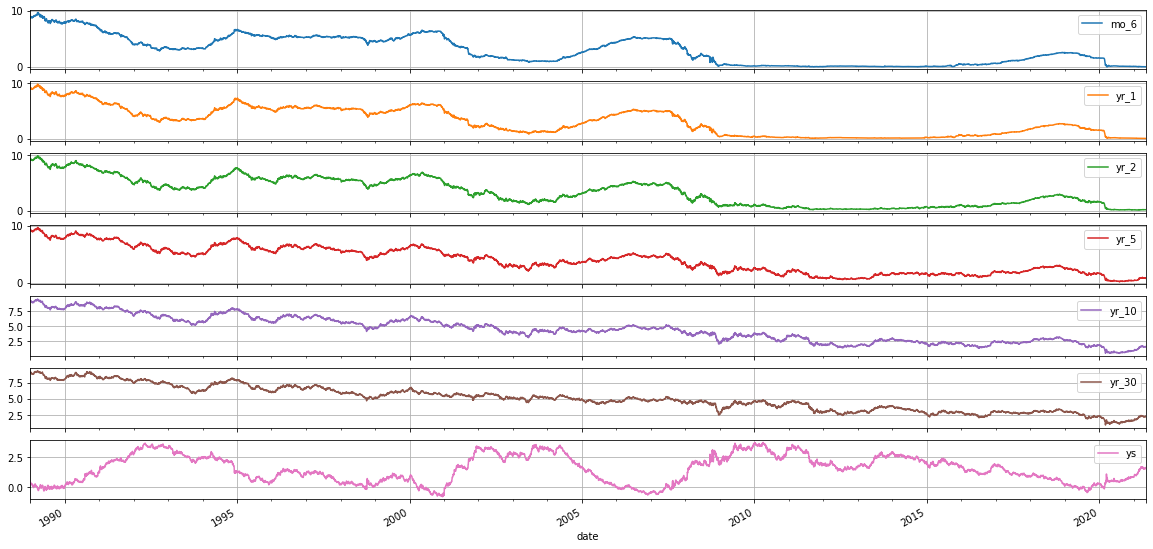

In [102]:
df.plot(subplots=True, grid=True)

(array([1630., 2217., 2304., 1521.,  772.]),
 array([0.52 , 2.322, 4.124, 5.926, 7.728, 9.53 ]),
 <BarContainer object of 5 artists>)

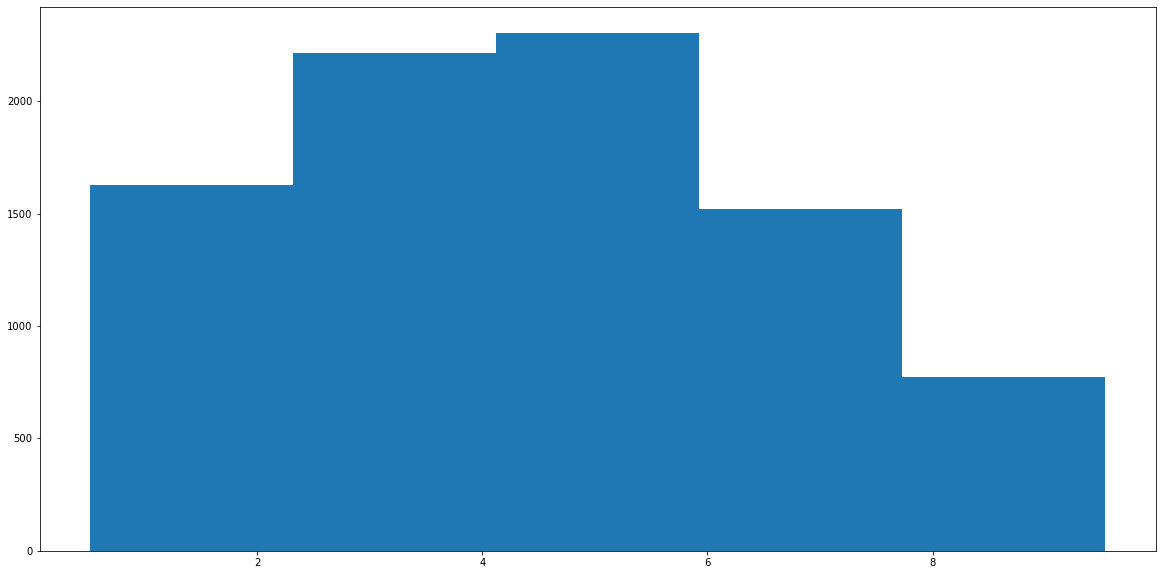

In [103]:
plt.hist(df['yr_10'], bins=5)

In [104]:
roll_mean = df['yr_10'].rolling(window=90, center=False).mean()
roll_std= df['yr_10'].rolling(window=90, center=False).std()

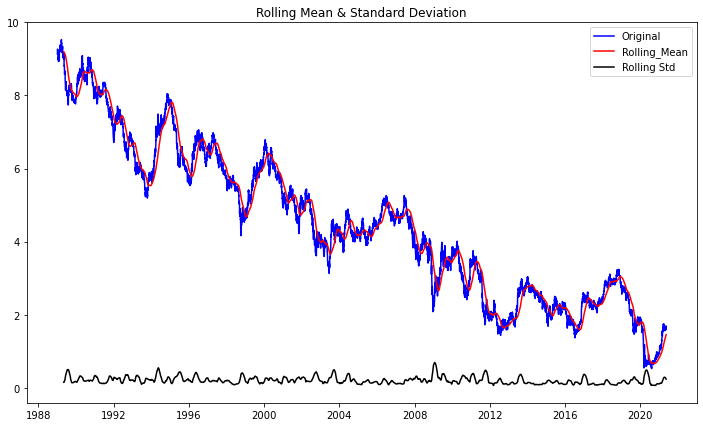

In [105]:
fig = plt.figure(figsize=(12,7))
plt.plot(df['yr_10'], color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling_Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

* The standard deviation doesn't seem to be too off.
* It's really hard to make a judgement based on this.

In [106]:
minus_rm = (df['yr_10'] - roll_mean).dropna()

In [107]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df['yr_10'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                   -1.843206
p-value                           0.359232
#Lags Used                       22.000000
Number of Observations Used    8421.000000
Critical Value (1%)              -3.431127
Critical Value (5%)              -2.861883
Critical Value (10%)             -2.566953
dtype: float64


* p-value is above 0.05, so we are not stationary

* Let's subract the rolling mean from the values

In [108]:
ys_month = df['yr_10'].resample('MS').mean()
ys_std = df['yr_10'].resample('MS').std()

In [109]:
minus_rm = (df['yr_10'] - roll_mean).dropna().resample('MS').mean()

In [110]:
ys_md = np.diff(ys_month)
ys_std = np.diff(ys_std)
ys_orig = np.array(ys_month)

date
1989-01-01    0.252727
1989-02-01    0.118500
1989-03-01   -0.040435
1989-04-01    0.003000
1989-05-01   -0.057391
                ...   
2021-01-01    0.982857
2021-02-01    1.198500
2021-03-01    1.558261
2021-04-01    1.595909
2021-05-01    1.586667
Freq: MS, Name: ys, Length: 389, dtype: float64

In [111]:
ys_md

array([ 0.07822727,  0.19036957, -0.18536957, -0.32506522, -0.57316206,
       -0.25536797,  0.09070393,  0.07786749, -0.18183983, -0.13727273,
       -0.03612554,  0.3547619 ,  0.2805    ,  0.11813636,  0.18993506,
       -0.02335404, -0.27521739, -0.01181818,  0.28442688,  0.1388913 ,
       -0.17497826, -0.32561265, -0.30995671,  0.00774327, -0.23769565,
        0.25614286, -0.06805195,  0.03003953,  0.21486957, -0.01182609,
       -0.37217391, -0.24190476, -0.13244306, -0.10850932, -0.33805195,
       -0.05822134,  0.32063043,  0.20077273, -0.06318182, -0.08909091,
       -0.12818182, -0.41355731, -0.26254658, -0.17116883,  0.17136364,
        0.28742424, -0.10681159, -0.16175983, -0.3412619 , -0.28828261,
       -0.00567194,  0.07188312, -0.0787013 , -0.15954545, -0.12545455,
       -0.32      , -0.02725108,  0.39861472,  0.04264822, -0.01983437,
        0.22709524,  0.5036087 ,  0.47453416,  0.22331169, -0.07909091,
        0.19863636, -0.06391304,  0.20982213,  0.29599567,  0.20

In [112]:
dftest = adfuller(ys_md)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -9.583504e+00
p-value                        2.127319e-16
#Lags Used                     4.000000e+00
Number of Observations Used    3.830000e+02
Critical Value (1%)           -3.447540e+00
Critical Value (5%)           -2.869116e+00
Critical Value (10%)          -2.570806e+00
dtype: float64


* We are definitely stationary now.  Let's plot this.

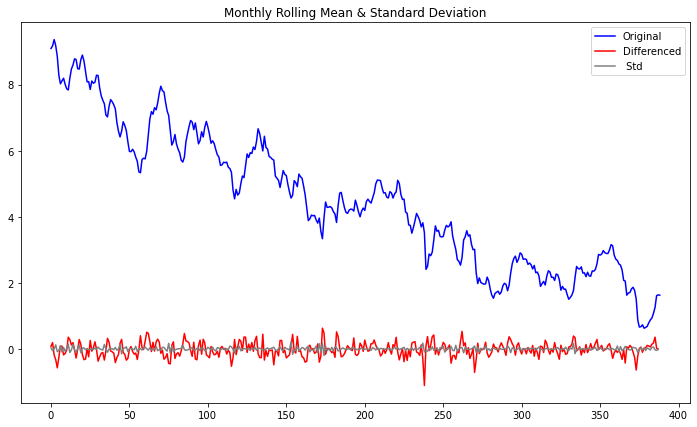

In [113]:
fig = plt.figure(figsize=(12,7))
plt.plot(ys_orig, color='blue', label='Original')
plt.plot(ys_md, color='red', label='Differenced')
plt.plot(ys_std, color='grey', label = ' Std')
plt.legend(loc='best')
plt.title('Monthly Rolling Mean & Standard Deviation')
plt.show(block=False)

### EWR

In [114]:
exp_roll_mean = df['yr_10'].ewm(halflife=45).mean()

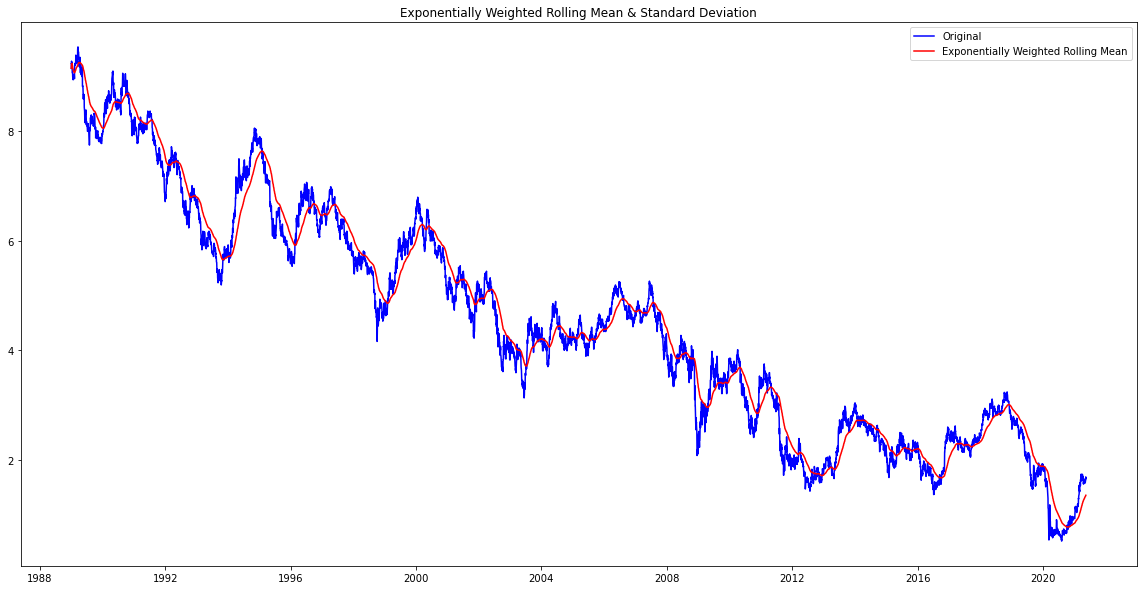

In [115]:

orig = plt.plot(df['yr_10'], color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

In [116]:
minus_erm =(df['yr_10'] - exp_roll_mean).dropna()
minus_erm

date
1989-01-02    0.000000
1989-01-03    0.044653
1989-01-04    0.022924
1989-01-05    0.054270
1989-01-06    0.027203
                ...   
2021-05-07    0.263626
2021-05-10    0.289138
2021-05-11    0.294566
2021-05-12    0.339299
2021-05-13    0.304571
Name: yr_10, Length: 8444, dtype: float64

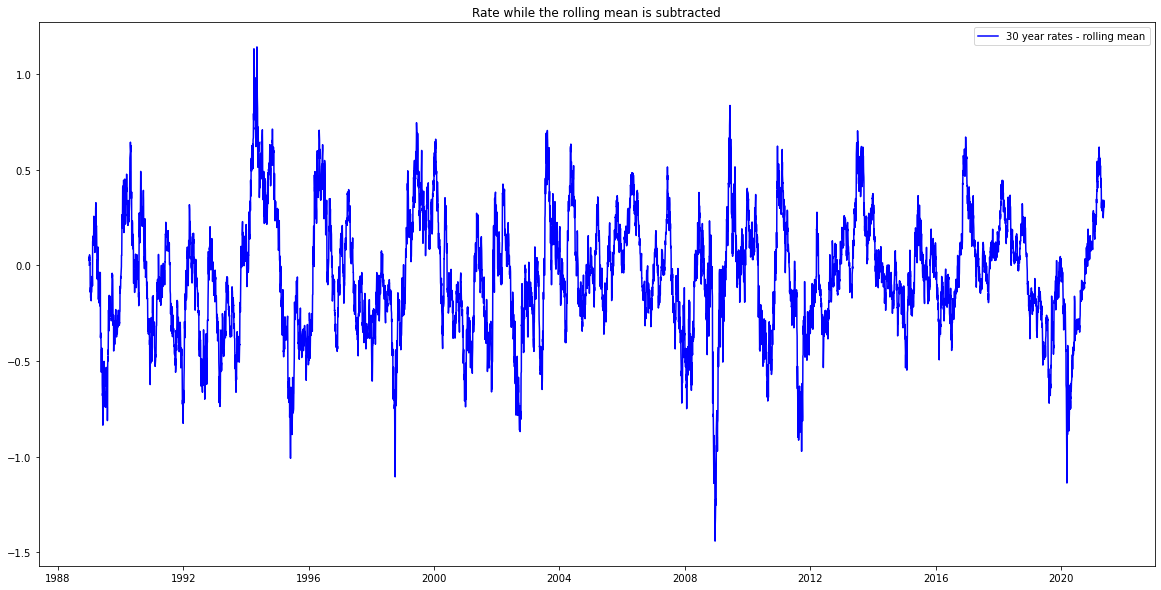

In [117]:
plt.plot(minus_erm, color='blue',label='30 year rates - rolling mean')
plt.legend(loc='best')
plt.title('Rate while the rolling mean is subtracted')
plt.show(block=False)

In [118]:
dts =minus_rm.groupby(pd.Grouper(freq='M'))

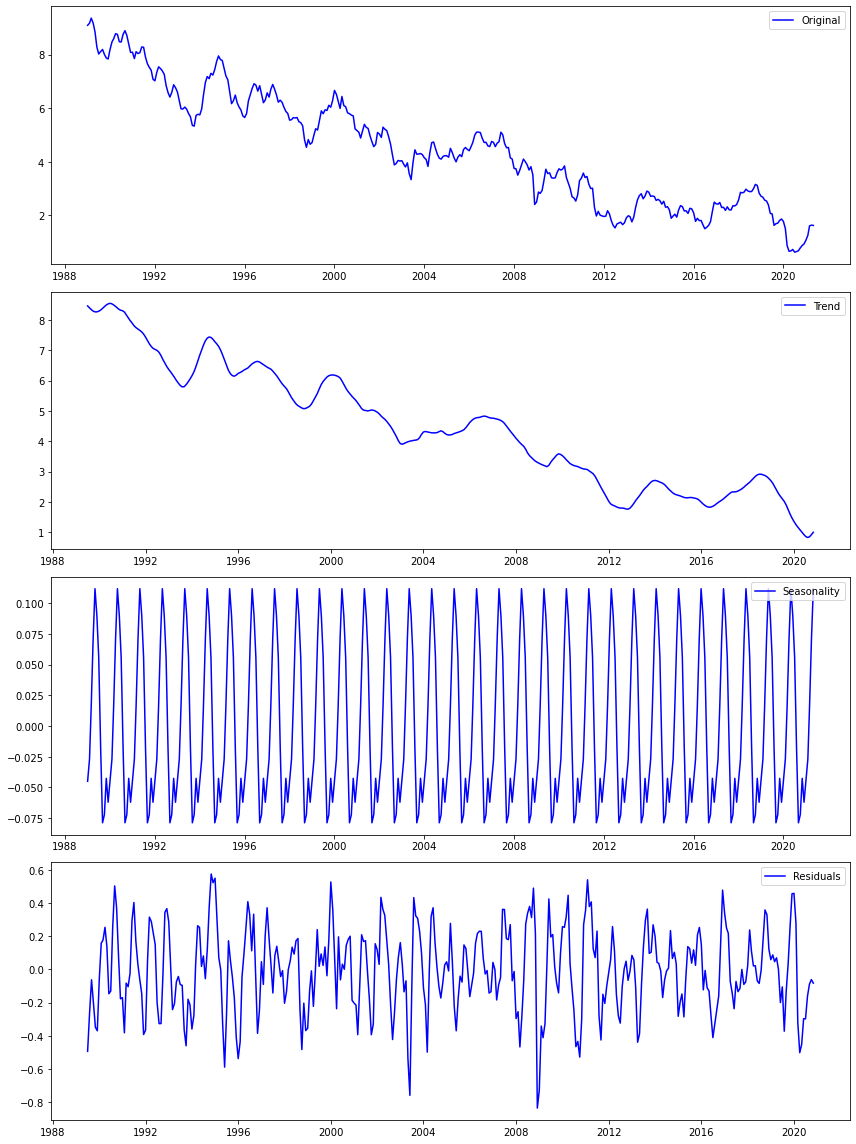

In [119]:
from statsmodels.tsa.seasonal import seasonal_decompose


decomposition = seasonal_decompose(ys_month)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,16))
plt.subplot(411)
plt.plot(ys_month, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

<AxesSubplot:xlabel='date', ylabel='yr_10'>

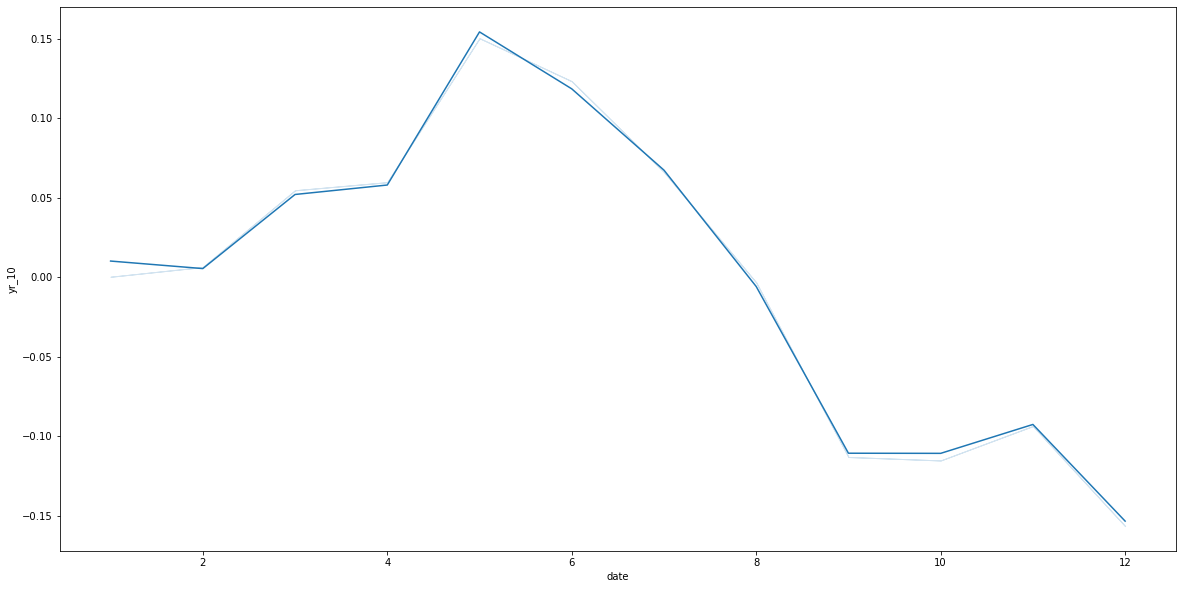

In [120]:
sns.lineplot(x=df.index.month, y=(df['yr_10']-df['yr_10'].mean()), ci=False)


<AxesSubplot:xlabel='date', ylabel='yr_10'>

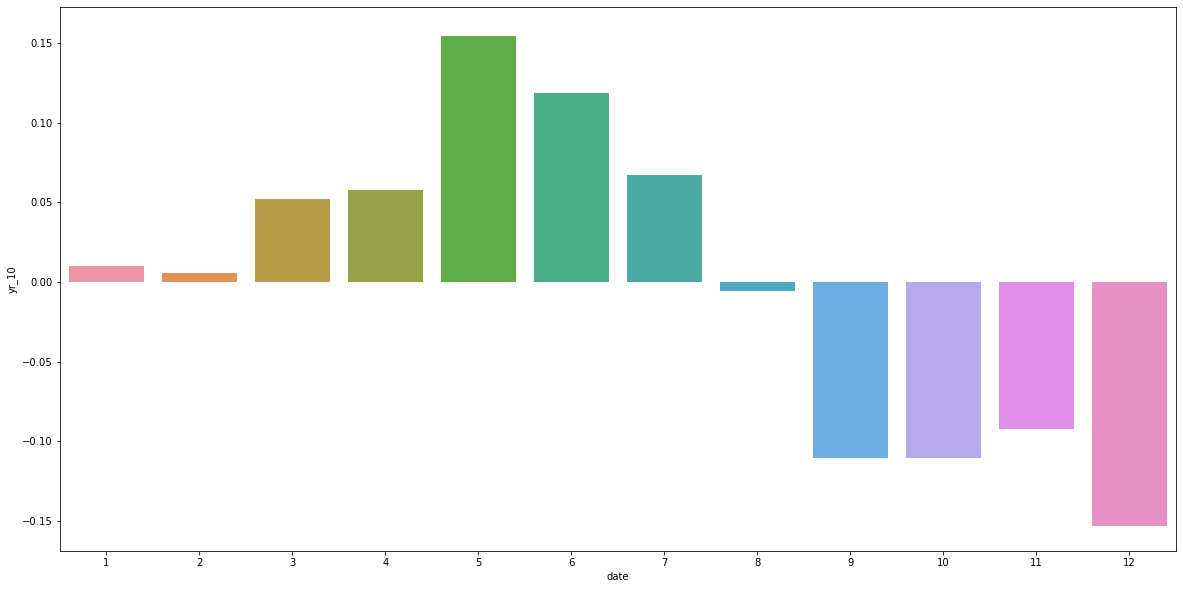

In [121]:
sns.barplot(x=df.index.month, y=(df['yr_10']-df['yr_10'].mean()), ci=False)

## Train Test Split

In [122]:
twenty = int(len(minus_rm) * 0.2)
train, test = minus_rm[:-twenty], minus_rm[-twenty:]

In [123]:
print(len(train))
print(len(test))

308
77


In [124]:
twenty

77

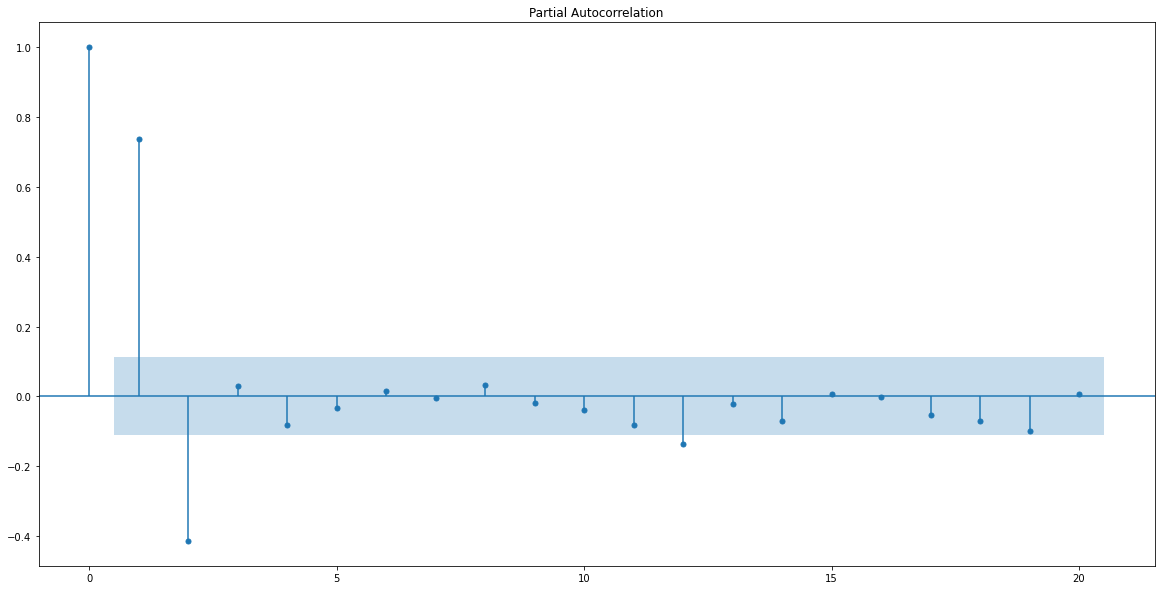

In [125]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_pacf(train, lags=20);

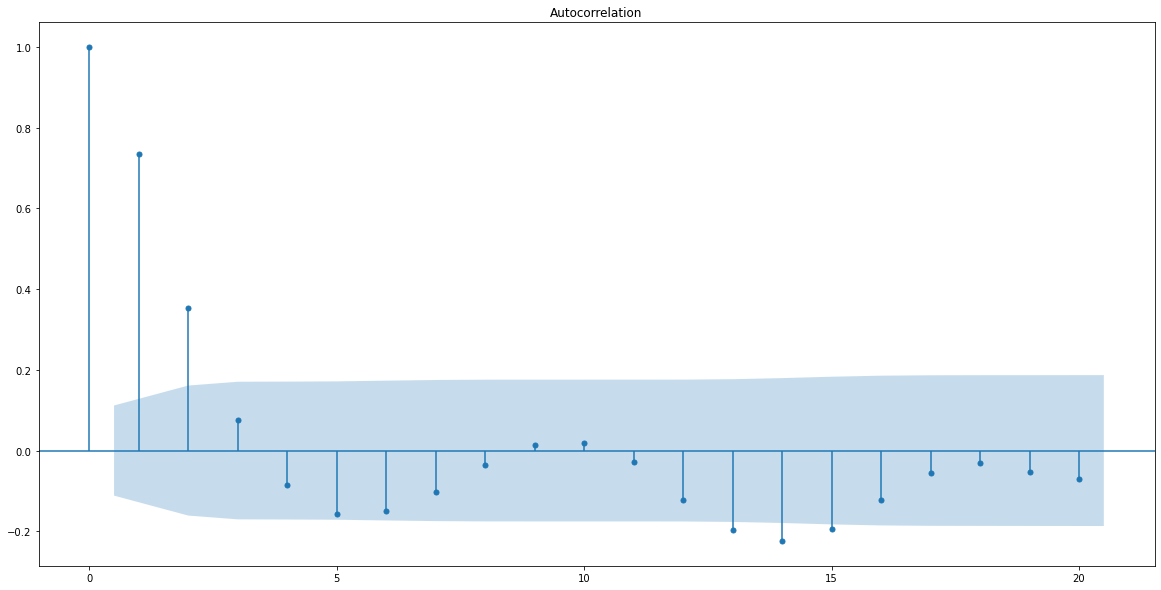

In [126]:
plot_acf(train, lags=20);

* Based on this, it looks like the p and q would be 3.

In [127]:
# Import ARMA
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm


In [128]:

p = q = (0,1,2,3)


combo, value = (None, None)
for ar in p:
    for ma in q:
        try:
            model = ARMA(np.asarray(train), order=(ar, ma)).fit()
            print('Combo:', (ar, ma),'AIC:', model.aic)

            if value is None or model.aic < value:
                combo, value = ((ar, ma), model.aic)
                print(f'\tBest Parameters Updated')
        except ValueError:
            pass
            
print(f'\n{"*"*20}\nOptimal ARMA order: {combo}') 


Combo: (0, 0) AIC: 144.7916273940807
	Best Parameters Updated
Combo: (0, 1) AIC: -69.5605705678363
	Best Parameters Updated
Combo: (0, 2) AIC: -131.53407293012583
	Best Parameters Updated
Combo: (0, 3) AIC: -140.46280770203612
	Best Parameters Updated
Combo: (1, 0) AIC: -93.27137195256296
Combo: (1, 1) AIC: -139.49033829650614
Combo: (1, 2) AIC: -141.91190005449175
	Best Parameters Updated
Combo: (1, 3) AIC: -140.5170906370845
Combo: (2, 0) AIC: -146.35839082084885
	Best Parameters Updated
Combo: (2, 1) AIC: -144.64037105584362
Combo: (2, 2) AIC: -153.34823073871166
	Best Parameters Updated
Combo: (2, 3) AIC: -153.1232511795854
Combo: (3, 0) AIC: -144.53041657852486
Combo: (3, 1) AIC: -143.06164056240118
Combo: (3, 2) AIC: -153.37841965354937
	Best Parameters Updated
Combo: (3, 3) AIC: -149.12929581826438

********************
Optimal ARMA order: (3, 2)


* These are all so close together.
* Best performance is for (3,0), but there are only modest gains after (0,1)

In [129]:
test

date
2015-01-01   -0.380929
2015-02-01   -0.159844
2015-03-01   -0.037061
2015-04-01   -0.066273
2015-05-01    0.207667
                ...   
2021-01-01    0.211815
2021-02-01    0.292617
2021-03-01    0.497667
2021-04-01    0.331990
2021-05-01    0.205654
Freq: MS, Name: yr_10, Length: 77, dtype: float64

In [130]:
def run_arma(trn, tst, p, q):

    model = ARMA(np.asarray(trn), order=(p,q)).fit()
    print(model.summary())

    pred = model.forecast(steps=77)[0]
    mse =  round(mean_squared_error(tst, pred), 3)

    print(f'Mean Sqared Error for Test: {mse}')

    return model, pred, mse



In [131]:
model_1, pred_1, mse_1 =run_arma(train, test, 2,2)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  308
Model:                     ARMA(2, 2)   Log Likelihood                  82.674
Method:                       css-mle   S.D. of innovations              0.184
Date:                Tue, 18 May 2021   AIC                           -153.348
Time:                        20:01:35   BIC                           -130.968
Sample:                             0   HQIC                          -144.399
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0407      0.003    -14.673      0.000      -0.046      -0.035
ar.L1.y        1.5587      0.053     29.444      0.000       1.455       1.662
ar.L2.y       -0.6156      0.053    -11.612      0.0

In [132]:
test

date
2015-01-01   -0.380929
2015-02-01   -0.159844
2015-03-01   -0.037061
2015-04-01   -0.066273
2015-05-01    0.207667
                ...   
2021-01-01    0.211815
2021-02-01    0.292617
2021-03-01    0.497667
2021-04-01    0.331990
2021-05-01    0.205654
Freq: MS, Name: yr_10, Length: 77, dtype: float64

In [133]:
test

date
2015-01-01   -0.380929
2015-02-01   -0.159844
2015-03-01   -0.037061
2015-04-01   -0.066273
2015-05-01    0.207667
                ...   
2021-01-01    0.211815
2021-02-01    0.292617
2021-03-01    0.497667
2021-04-01    0.331990
2021-05-01    0.205654
Freq: MS, Name: yr_10, Length: 77, dtype: float64

In [134]:
run_arma(train, test, 3,2)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  308
Model:                     ARMA(3, 2)   Log Likelihood                  83.689
Method:                       css-mle   S.D. of innovations              0.183
Date:                Tue, 18 May 2021   AIC                           -153.378
Time:                        20:01:36   BIC                           -127.268
Sample:                             0   HQIC                          -142.938
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0407      0.003    -13.462      0.000      -0.047      -0.035
ar.L1.y        1.7699      0.159     11.151      0.000       1.459       2.081
ar.L2.y       -1.0052      0.278     -3.619      0.0

(<statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x20ccd4be2e0>,
 array([-0.17173731, -0.14610337, -0.11747828, -0.09565844, -0.08091859,
        -0.07129837, -0.064922  , -0.06049247, -0.0572254 , -0.05467811,
        -0.05260799, -0.05088081, -0.04941838, -0.04817092, -0.04710329,
        -0.04618839, -0.0454041 , -0.04473179, -0.04415554, -0.04366169,
        -0.0432385 , -0.04287589, -0.04256518, -0.04229897, -0.04207088,
        -0.04187545, -0.04170801, -0.04156454, -0.04144163, -0.04133631,
        -0.04124608, -0.04116876, -0.04110252, -0.04104577, -0.04099714,
        -0.04095548, -0.04091978, -0.0408892 , -0.04086299, -0.04084054,
        -0.0408213 , -0.04080482, -0.0407907 , -0.0407786 , -0.04076823,
        -0.04075935, -0.04075174, -0.04074522, -0.04073963, -0.04073485,
        -0.04073075, -0.04072723, -0.04072422, -0.04072164, -0.04071943,
        -0.04071754, -0.04071592, -0.04071453, -0.04071334, -0.04071232,
        -0.04071144, -0.04071069, -0.04071005, -0.040709

In [135]:
run_arma(train, test, 3, 2)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  308
Model:                     ARMA(3, 2)   Log Likelihood                  83.689
Method:                       css-mle   S.D. of innovations              0.183
Date:                Tue, 18 May 2021   AIC                           -153.378
Time:                        20:01:37   BIC                           -127.268
Sample:                             0   HQIC                          -142.938
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0407      0.003    -13.462      0.000      -0.047      -0.035
ar.L1.y        1.7699      0.159     11.151      0.000       1.459       2.081
ar.L2.y       -1.0052      0.278     -3.619      0.0

(<statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x20ccd4babe0>,
 array([-0.17173731, -0.14610337, -0.11747828, -0.09565844, -0.08091859,
        -0.07129837, -0.064922  , -0.06049247, -0.0572254 , -0.05467811,
        -0.05260799, -0.05088081, -0.04941838, -0.04817092, -0.04710329,
        -0.04618839, -0.0454041 , -0.04473179, -0.04415554, -0.04366169,
        -0.0432385 , -0.04287589, -0.04256518, -0.04229897, -0.04207088,
        -0.04187545, -0.04170801, -0.04156454, -0.04144163, -0.04133631,
        -0.04124608, -0.04116876, -0.04110252, -0.04104577, -0.04099714,
        -0.04095548, -0.04091978, -0.0408892 , -0.04086299, -0.04084054,
        -0.0408213 , -0.04080482, -0.0407907 , -0.0407786 , -0.04076823,
        -0.04075935, -0.04075174, -0.04074522, -0.04073963, -0.04073485,
        -0.04073075, -0.04072723, -0.04072422, -0.04072164, -0.04071943,
        -0.04071754, -0.04071592, -0.04071453, -0.04071334, -0.04071232,
        -0.04071144, -0.04071069, -0.04071005, -0.040709

In [136]:
from statsmodels.tsa.arima_model import ARIMA

### Non stationary train test split

In [137]:
twenty = int(len(ys_month) * 0.2)
train, test = ys_month[:-twenty], ys_month[-twenty:]

In [138]:
p = d = q = (0,1,2,3)


combo, value = (None, None)
for ar in p:
    for ma in q:
        for diff in d:
            try:
                model = ARIMA(train, order=(ar, diff, ma)).fit()
                print('Combo:', (ar, diff, ma),'AIC:', model.aic)

                if value is None or model.aic < value:
                    combo, value = ((ar, diff, ma), model.aic)
                    print(f'\tBest Parameters Updated')
            except ValueError:
                pass
            
print(f'\n{"*"*20}\nOptimal ARIMA order: {combo}')

Combo: (0, 0, 0) AIC: 1285.3936202229456
	Best Parameters Updated
Combo: (0, 1, 0) AIC: -36.87842117812619
	Best Parameters Updated
Combo: (0, 2, 0) AIC: 78.66705977188957
Combo: (0, 0, 1) AIC: 898.1803554675213
Combo: (0, 1, 1) AIC: -65.8383980147471
	Best Parameters Updated
Combo: (0, 2, 1) AIC: -28.244003633396915
Combo: (0, 1, 2) AIC: -64.58157628579329
Combo: (0, 2, 2) AIC: -57.586624210916625
Combo: (0, 1, 3) AIC: -62.72103386730328
Combo: (0, 2, 3) AIC: -56.247657368502246
Combo: (1, 0, 0) AIC: -27.30268086306978
Combo: (1, 1, 0) AIC: -59.51021756506486
Combo: (1, 2, 0) AIC: 56.335469881689164
Combo: (1, 0, 1) AIC: -57.898201511772754
Combo: (1, 1, 1) AIC: -64.4878488500259
Combo: (1, 2, 1) AIC: -51.323479112984614
Combo: (1, 0, 2) AIC: -56.33258013522675
Combo: (1, 1, 2) AIC: -74.98287326813136
	Best Parameters Updated
Combo: (1, 2, 2) AIC: -56.17206764895559
Combo: (1, 0, 3) AIC: -54.35784503730508
Combo: (1, 2, 3) AIC: -54.890695538215255
Combo: (2, 0, 0) AIC: -51.91570284322

In [139]:
arima_model = ARIMA(train, order=(1,1,2)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.yr_10   No. Observations:                  311
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  42.491
Method:                       css-mle   S.D. of innovations              0.210
Date:                Tue, 18 May 2021   AIC                            -74.983
Time:                        20:01:56   BIC                            -56.284
Sample:                    02-01-1989   HQIC                           -67.509
                         - 12-01-2014                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0202      0.002    -12.355      0.000      -0.023      -0.017
ar.L1.D.yr_10     0.8975      0.027     32.653      0.000       0.844       0.951
ma.L1.D.yr_10    -0.6240      0.056    -11.231      0.000      -0.733      -0.515
ma.L2.D.yr_10    -0.3760      0.055     -6.845      0.000      -0.484      -0.268
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1142           +0.0000j            1.1142            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -2.6595           +0.0000j            2.6595            0.5000
-----------------------------------------------------------------------------
"""

In [140]:
def get_MSE(model, trn, tst):
    pred = model.forecast(steps=len(tst))[0]
    mse_tst =  round(mean_squared_error(tst, pred), 3)

    print(mse_tst)

In [141]:
get_MSE(arima_model, train, test)

1.024


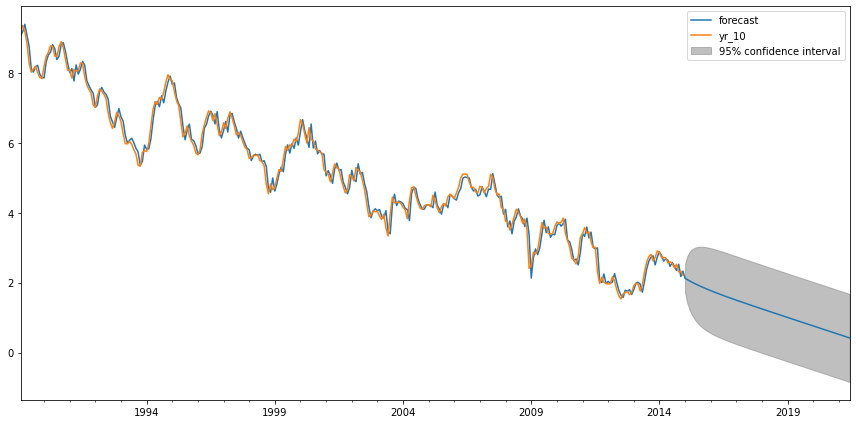

In [142]:
fig, ax = plt.subplots(figsize=(12, 6))
arima_model.plot_predict(1, len(train)+77, ax=ax)
fig.tight_layout()

In [143]:
arima_model = ARIMA(train, order=(0,1,1)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.yr_10   No. Observations:                  311
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  35.919
Method:                       css-mle   S.D. of innovations              0.216
Date:                Tue, 18 May 2021   AIC                            -65.838
Time:                        20:01:57   BIC                            -54.619
Sample:                    02-01-1989   HQIC                           -61.354
                         - 12-01-2014                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0223      0.016     -1.359      0.174      -0.054       0.010
ma.L1.D.yr_10     0.3414      0.055      6.158      0.000       0.233       0.450
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.9293           +0.0000j            2.9293            0.5000
-----------------------------------------------------------------------------
"""

In [144]:
get_MSE(arima_model, train, test)

0.912


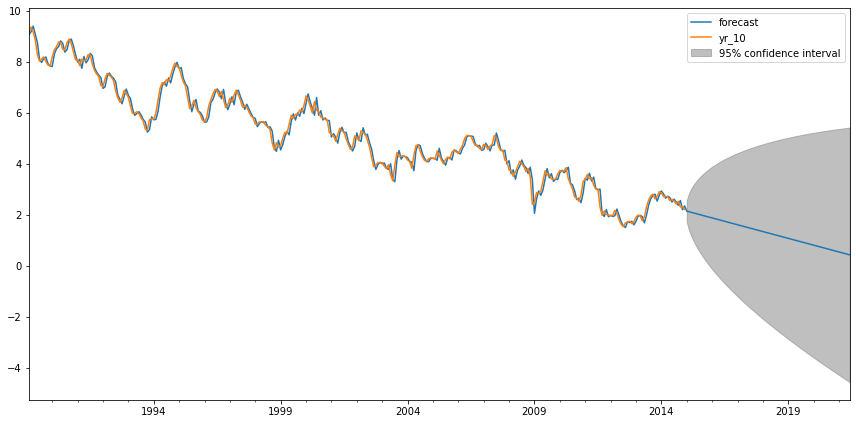

In [145]:
fig, ax = plt.subplots(figsize=(12, 6))
arima_model.plot_predict(1, len(train)+77, ax=ax)
fig.tight_layout()

In [146]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [147]:
# Setting up parameter combinations.
p = q = (0, 1,2)
d = 0

pdq = [(ar, d, ma) for ar in p for ma in q]
pdqs = [(c[0], d, c[2], 12) for c in pdq]

# Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        try:
            model = SARIMAX(
               np.asarray(train), 
               order=pdq_combo,
               seasonal_order=pdqs_combo,
               enforce_stationarity=False,
               enforce_invertibility=False
               )
            output = model.fit()

            if value is None or output.aic < value:
                combo, value = ((pdq_combo, pdqs_combo), output.aic)
                print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
        except ValueError:
            pass      
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 1935.2468232450065
SARIMA Combos: ((0, 0, 0), (0, 0, 1, 12)) AIC: 1531.1891946317896
SARIMA Combos: ((0, 0, 0), (0, 0, 2, 12)) AIC: 1280.9224210982445
SARIMA Combos: ((0, 0, 0), (1, 0, 0, 12)) AIC: 739.4736492715797
SARIMA Combos: ((0, 0, 0), (1, 0, 1, 12)) AIC: 620.6342725985266
SARIMA Combos: ((0, 0, 0), (1, 0, 2, 12)) AIC: 595.8406669575514
SARIMA Combos: ((0, 0, 0), (2, 0, 2, 12)) AIC: 588.1165472281905
SARIMA Combos: ((0, 0, 1), (1, 0, 0, 12)) AIC: 417.75412422520856
SARIMA Combos: ((0, 0, 1), (1, 0, 1, 12)) AIC: 307.8223956866789
SARIMA Combos: ((0, 0, 1), (1, 0, 2, 12)) AIC: 296.89509658620165
SARIMA Combos: ((0, 0, 1), (2, 0, 2, 12)) AIC: 294.1103310453484
SARIMA Combos: ((0, 0, 2), (1, 0, 0, 12)) AIC: 282.3449155359662
SARIMA Combos: ((0, 0, 2), (1, 0, 1, 12)) AIC: 190.45672007328517
SARIMA Combos: ((0, 0, 2), (1, 0, 2, 12)) AIC: 139.5925390473015
SARIMA Combos: ((1, 0, 0), (0, 0, 0, 12)) AIC: -38.58540383366892
SARIMA Combos: ((1

In [148]:
 sari_model = SARIMAX(
    np.asarray(train), 
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
    ).fit()

print(sari_model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  312
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  36.154
Date:                Tue, 18 May 2021   AIC                            -66.308
Time:                        20:03:55   BIC                            -55.099
Sample:                             0   HQIC                           -61.827
                                - 312                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9943      0.003    323.234      0.000       0.988       1.000
ma.L1          0.3408      0.048      7.109      0.000       0.247       0.435
sigma2         0.0463      0.003     15.231      0.0

In [149]:
sari_pred = sari_model.forecast(steps=len(test))
sari_mse = round(mean_squared_error(test, sari_pred), 3)

In [150]:
sari_mse

0.439

In [151]:
test.index.min()

Timestamp('2015-01-01 00:00:00', freq='MS')

In [152]:
preds = sari_model.get_forecast( steps=150,
    dynamic=False)

In [153]:
preds.predicted_mean

array([2.14902736, 2.13677983, 2.12460209, 2.11249375, 2.10045442,
       2.08848371, 2.07658122, 2.06474656, 2.05297934, 2.04127919,
       2.02964573, 2.01807856, 2.00657731, 1.99514161, 1.98377108,
       1.97246536, 1.96122407, 1.95004684, 1.93893332, 1.92788313,
       1.91689591, 1.90597132, 1.89510898, 1.88430855, 1.87356968,
       1.862892  , 1.85227518, 1.84171886, 1.83122271, 1.82078638,
       1.81040952, 1.8000918 , 1.78983288, 1.77963243, 1.76949012,
       1.7594056 , 1.74937856, 1.73940867, 1.72949559, 1.71963901,
       1.7098386 , 1.70009405, 1.69040503, 1.68077123, 1.67119233,
       1.66166803, 1.652198  , 1.64278195, 1.63341956, 1.62411053,
       1.61485455, 1.60565132, 1.59650054, 1.58740191, 1.57835514,
       1.56935992, 1.56041597, 1.55152299, 1.5426807 , 1.53388879,
       1.525147  , 1.51645502, 1.50781258, 1.49921939, 1.49067518,
       1.48217966, 1.47373256, 1.4653336 , 1.45698251, 1.44867901,
       1.44042283, 1.43221371, 1.42405137, 1.41593555, 1.40786

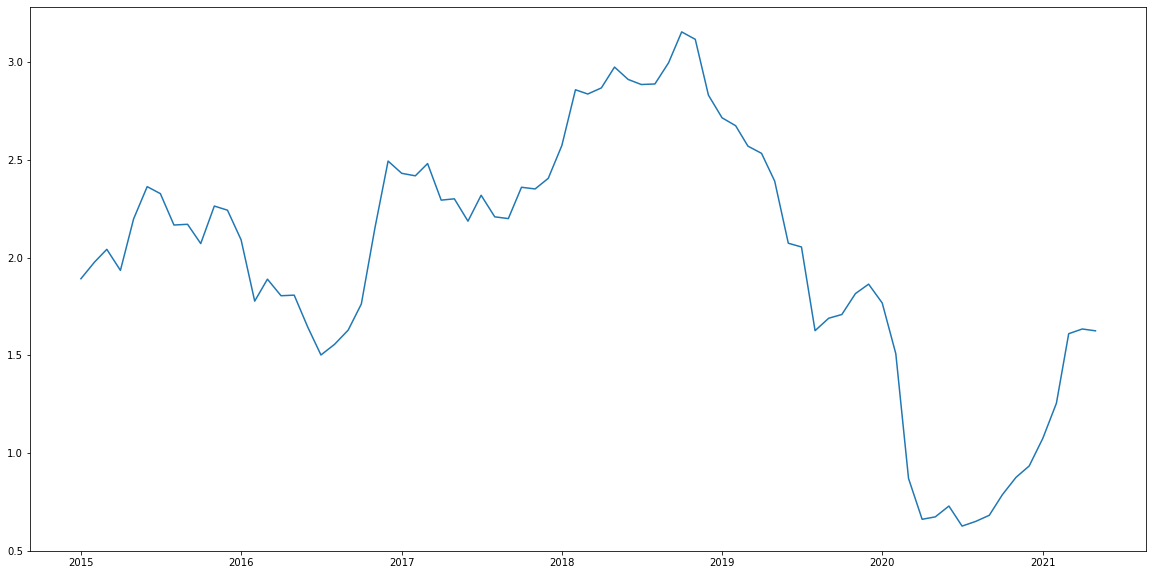

In [154]:
plt.plot(test)

In [155]:
dr = pd.date_range(start='2015', periods=77, freq='M')

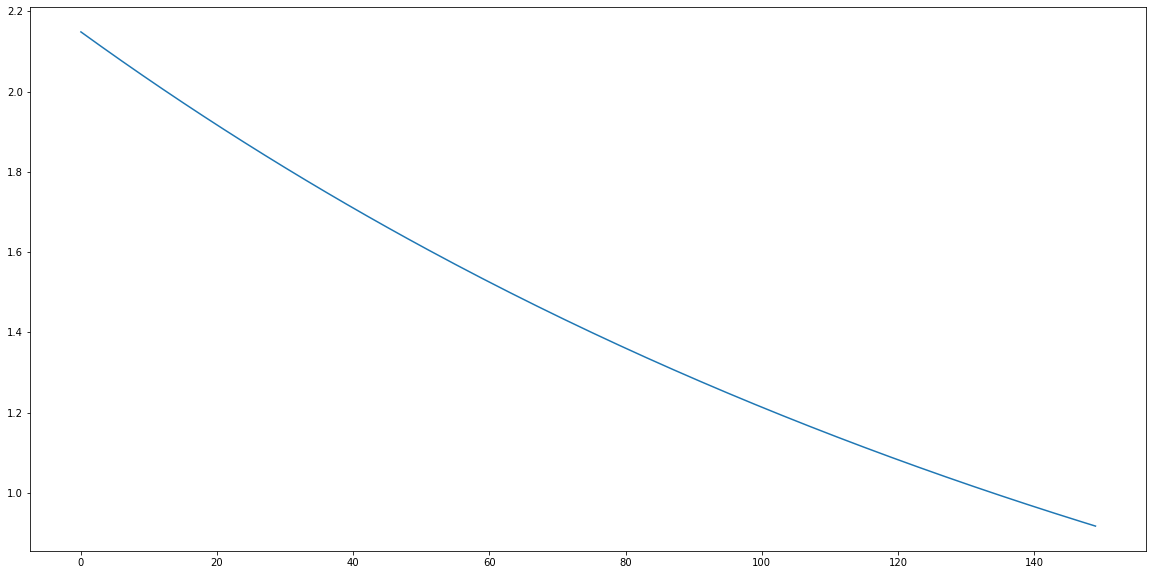

In [156]:
plt.plot(preds.predicted_mean )

In [157]:
minus_rm

date
1989-05-01   -0.365550
1989-06-01   -0.759096
1989-07-01   -0.745286
1989-08-01   -0.336338
1989-09-01   -0.039926
                ...   
2021-01-01    0.211815
2021-02-01    0.292617
2021-03-01    0.497667
2021-04-01    0.331990
2021-05-01    0.205654
Freq: MS, Name: yr_10, Length: 385, dtype: float64

# RNN

In [166]:
ml_data = ys_month
p_60 = int(len(ml_data) * 0.7)
p_80 = int(len(ml_data) * 0.85)

train = ml_data[:p_60]
val = ml_data[p_60:p_80]
test = ml_data[p_80:]

In [167]:
X_train, y_train = (train), (train.shift(-1, freq='MS'))
X_val, y_val =(val), (val.shift(-1, freq='MS'))
X_test, y_test =(test), (test.shift(-1, freq='MS'))

In [168]:
X_train, y_train = np.array(X_train[:-1]), np.array(y_train[1:])
X_val, y_val =  np.array(X_val[:-1]), np.array(y_val[1:])
X_test, y_test = np.array(X_test[:-1]), np.array(y_test[1:])

In [169]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))
X_val = np.reshape(X_val, (X_val.shape[0], 1, 1))
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(271, 1, 1)
(57, 1, 1)
(58, 1, 1)


In [170]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras import optimizers
import tensorflow as tf

In [171]:
batch_size = 1
look_back = 1
model = Sequential()
model.add(LSTM(6, batch_input_shape=(batch_size, look_back, 1),
                return_sequences=True, stateful=True))
model.add(LSTM(6, return_sequences=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=50, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/50
271/271 - 1s - loss: 20.5312 - val_loss: 0.8479
Epoch 2/50
271/271 - 0s - loss: 5.2462 - val_loss: 5.7279
Epoch 3/50
271/271 - 0s - loss: 3.0708 - val_loss: 8.5601
Epoch 4/50
271/271 - 0s - loss: 2.6925 - val_loss: 10.0612
Epoch 5/50
271/271 - 0s - loss: 2.6157 - val_loss: 10.2421
Epoch 6/50
271/271 - 0s - loss: 2.5645 - val_loss: 4.3532
Epoch 7/50
271/271 - 0s - loss: 1.8128 - val_loss: 0.3484
Epoch 8/50
271/271 - 0s - loss: 0.9948 - val_loss: 0.0710
Epoch 9/50
271/271 - 0s - loss: 0.6206 - val_loss: 0.1345
Epoch 10/50
271/271 - 0s - loss: 0.4458 - val_loss: 0.2071
Epoch 11/50
271/271 - 0s - loss: 0.3435 - val_loss: 0.2850
Epoch 12/50
271/271 - 0s - loss: 0.2766 - val_loss: 0.2091
Epoch 13/50
271/271 - 0s - loss: 0.2382 - val_loss: 0.1812
Epoch 14/50
271/271 - 0s - loss: 0.1904 - val_loss: 0.1316
Epoch 15/50
271/271 - 0s - loss: 0.1626 - val_loss: 0.1283
Epoch 16/50
271/271 - 0s - loss: 0.1389 - val_loss: 0.0840
Epoch 17/50
271/271 - 0s - loss: 0.1245 - val_loss: 0.0581
Epo

Train: 0.803, Test: 0.909


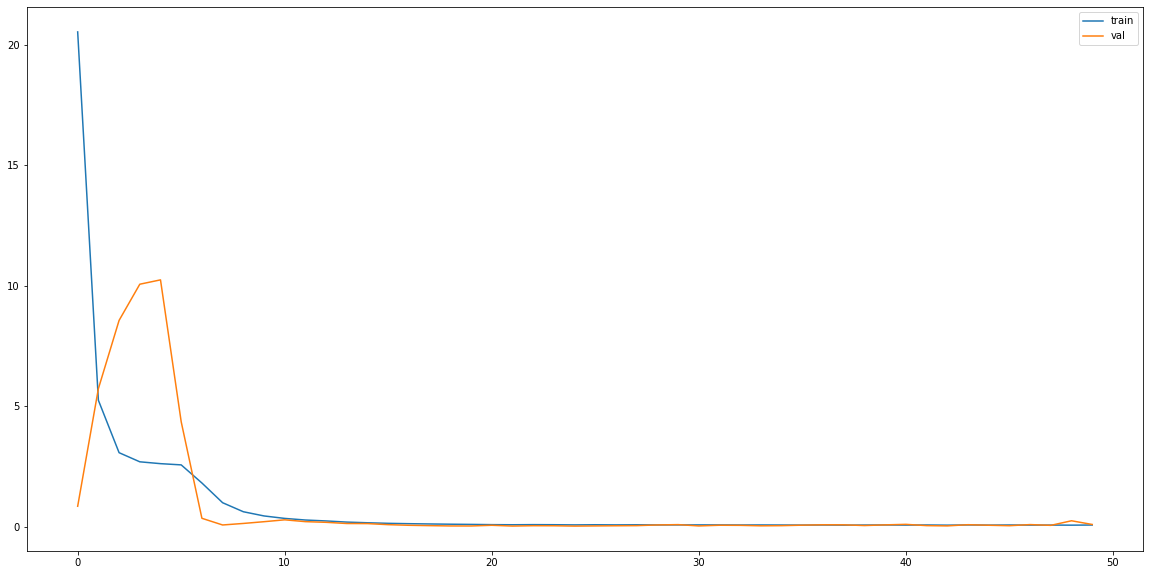

In [172]:
train_acc = model.evaluate(X_train, y_train, verbose=0)
test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [173]:
testPredict = model.predict(X_test, batch_size=batch_size)
trainPredict = model.predict(X_train, batch_size=batch_size)

In [174]:
testPredict

array([[[2.1641722]],

       [[2.0903754]],

       [[2.1004796]],

       [[2.1458778]],

       [[2.3203745]],

       [[2.560413 ]],

       [[2.545004 ]],

       [[2.5325708]],

       [[2.5721054]],

       [[2.4612656]],

       [[2.45123  ]],

       [[2.3889804]],

       [[2.4529653]],

       [[2.4017441]],

       [[2.3886933]],

       [[2.4783888]],

       [[2.485611 ]],

       [[2.5187812]],

       [[2.6357265]],

       [[2.8698921]],

       [[2.8628278]],

       [[2.8864613]],

       [[2.979568 ]],

       [[2.9269433]],

       [[2.9020538]],

       [[2.9036677]],

       [[2.9981122]],

       [[3.1475415]],

       [[3.1129427]],

       [[2.8611197]],

       [[2.759848 ]],

       [[2.7247033]],

       [[2.6470928]],

       [[2.6155643]],

       [[2.5209231]],

       [[2.3416579]],

       [[2.3060365]],

       [[2.1507487]],

       [[2.1299586]],

       [[2.1364603]],

       [[2.1733441]],

       [[2.2008486]],

       [[2.1732883]],

       [[2.

In [175]:
y_test

array([1.55652174, 1.62909091, 1.76285714, 2.15227273, 2.49454545,
       2.43181818, 2.419     , 2.48173913, 2.2945    , 2.30130435,
       2.18681818, 2.31952381, 2.20913043, 2.2       , 2.36045455,
       2.35181818, 2.40619048, 2.57434783, 2.8595    , 2.83772727,
       2.86904762, 2.97565217, 2.91238095, 2.88636364, 2.88913043,
       2.997     , 3.15565217, 3.11772727, 2.83190476, 2.71608696,
       2.6755    , 2.57095238, 2.53409091, 2.39173913, 2.074     ,
       2.05478261, 1.62636364, 1.69      , 1.70913043, 1.81619048,
       1.86454545, 1.76826087, 1.5085    , 0.87      , 0.66090909,
       0.67333333, 0.72863636, 0.62608696, 0.65      , 0.68136364,
       0.78727273, 0.87571429, 0.93391304, 1.0752381 , 1.255     ,
       1.61086957, 1.635     , 1.62555556])